In [6]:
df_actions

,date,actions
0,2019-01-02,[23]
1,2019-01-03,[80]
2,2019-01-04,[-72]
3,2019-01-07,[-31]
4,2019-01-08,[0]
...,...,...
245,2019-12-20,[-2]
246,2019-12-23,[-57]
247,2019-12-24,[0]
248,2019-12-26,[0]


In [46]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import datetime
from sklearn import preprocessing
from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.env.env_stocktrading_stoploss import StockTradingEnvStopLoss
from finrl.env.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot
# Diable the warnings
import warnings

warnings.filterwarnings('ignore')
# set the period
start = '2012-12-31'
end = '2020-01-01'
# d1 = start.strftime('%Y-%m-%d')
# d2 = end.strftime('%Y-%m-%d')

# collect to historical
stock = 'MSFT'
db = sqlite3.connect("db3.db")
dataSet = pd.read_sql(
    con=db,
    sql=f'SELECT date, Open, High, Low, Close, Volume  FROM "{stock}" WHERE Date BETWEEN  "{start}" and "{end}"')
dataSet['tic'] = stock
dataSet.columns = ['date','open','high','low','close','volume','tic']

# dataSet = YahooDownloader(start_date='2013-01-01',
#                           end_date='2020-01-01',
#                           ticker_list=[stock]).fetch_data()

# print(dataSet.tail())
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
add_TA = ['macd',"boll_ub","boll_lb","rsi_30", "cci_30","close_30_sma",'kdjk','kdjd','wr_30','wr_10','cci_10','rsi_10']
information_cols = add_TA + tech_indicator_list
fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list= add_TA, use_turbulence=False,
                     user_defined_feature=False)

processeDataSet = fe.preprocess_data(dataSet)
train = data_split(processeDataSet, start='2013-01-01', end='2019-01-01')
trade = data_split(processeDataSet, start='2019-01-01', end='2020-01-01')

# feature_list = list(train.columns)
# feature_list.remove('date')
# feature_list.remove('tic')
# feature_list.remove('close')
# print(feature_list)

# data_normaliser = preprocessing.StandardScaler()
# train[feature_list] = data_normaliser.fit_transform(train[feature_list])
# trade[feature_list] = data_normaliser.transform(trade[feature_list])

stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(add_TA) * stock_dimension

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": add_TA, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4  
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)
print(e_train_gym)
env_train, _ = e_train_gym.get_sb_env()

agent = DRLAgent(env=env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c", model_kwargs=A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_a2c, environment=e_trade_gym)
df_actions.tail(15)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1763, 8)
Successfully added technical indicators
caching data


KeyError: True

In [44]:
trade

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,close_30_sma,kdjk,kdjd,wr_30,wr_10,cci_10,rsi_10
0,2019-01-02,99.550003,101.750000,98.940002,98.375481,35329300,MSFT,2,-1.904370,110.230700,92.571463,45.769235,-81.408203,102.189424,27.310237,17.887288,77.309960,65.824441,3.907082,44.865454
1,2019-01-03,100.099998,100.190002,97.199997,94.756454,42579100,MSFT,3,-2.104556,109.218657,92.154376,42.780437,-114.386191,101.836275,20.771899,18.848825,95.907218,93.835484,-65.277302,37.029906
2,2019-01-04,99.720001,102.510002,98.930000,99.163513,44060600,MSFT,4,-1.885853,108.601422,92.130499,47.129694,-59.759384,101.749043,33.034930,23.577527,73.260461,49.724494,67.465773,49.065869
3,2019-01-07,101.639999,103.269997,100.980003,99.289970,35656100,MSFT,0,-1.682925,107.786340,92.251932,47.248714,-43.232381,101.760392,41.106611,29.420555,72.610629,42.750025,106.561453,49.374379
4,2019-01-08,103.040001,103.970001,101.709999,100.009888,31514400,MSFT,1,-1.447328,107.633426,92.208327,47.938930,-30.169156,101.750339,47.550553,35.463887,68.911157,39.561565,107.716568,51.242471
5,2019-01-09,103.860001,104.879997,103.239998,101.439995,32280800,MSFT,2,-1.132167,107.183089,92.335675,49.302104,-8.146407,101.789253,51.511673,40.813149,61.562199,31.501859,152.137425,54.914518
6,2019-01-10,103.220001,103.750000,102.379997,100.788193,30067600,MSFT,3,-0.924340,106.430341,92.602969,48.700868,-22.348379,101.696183,49.914881,43.847060,64.911644,48.252436,90.809685,52.897068
7,2019-01-11,103.190002,103.440002,101.639999,100.009888,28314200,MSFT,4,-0.813066,105.398186,93.024168,47.978130,-31.176385,101.555442,45.472293,44.388804,68.911157,63.412882,47.767720,50.438570
8,2019-01-14,101.900002,102.870003,101.260002,99.280251,28437100,MSFT,0,-0.774824,104.010002,93.692437,47.297421,-38.378025,101.261314,39.343740,42.707116,72.660577,72.913366,12.168360,48.109493
9,2019-01-15,102.510002,105.050003,101.879997,102.159920,31587600,MSFT,1,-0.506315,103.802897,93.800310,50.183137,1.499009,101.093334,47.290387,44.234873,57.862687,36.816319,98.807105,56.847629


{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_5
day: 1508, episode: 70
begin_total_asset: 100000.00
end_total_asset: 129249.72
total_reward: 29249.72
total_cost: 1893.66
total_trades: 1435
Sharpe: 0.680
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.29e+05 |
|    total_cost       | 1.89e+03 |
|    total_reward     | 2.92e+04 |
|    total_reward_pct | 29.2     |
|    total_trades     | 1435     |
| time/               |          |
|    fps              | 1325     |
|    iterations       | 1        |
|    time_elapsed     | 1        |
|    total_timesteps  | 2048     |
----------------------------------
-------------------------------------------
| environment/            |               |
|    portfolio_value      | 1.72e+05      |
|    total_cost           | 1.98e+03      |
|    total_reward         | 7.22e+04      |
|    total_reward_pct     | 72.2   

day: 1508, episode: 80
begin_total_asset: 100000.00
end_total_asset: 343597.53
total_reward: 243597.53
total_cost: 1199.33
total_trades: 1500
Sharpe: 1.027
-------------------------------------------
| environment/            |               |
|    portfolio_value      | 3.83e+05      |
|    total_cost           | 1.14e+03      |
|    total_reward         | 2.83e+05      |
|    total_reward_pct     | 283           |
|    total_trades         | 1496          |
| time/                   |               |
|    fps                  | 1079          |
|    iterations           | 9             |
|    time_elapsed         | 17            |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 0.00040645144 |
|    clip_fraction        | 0.000977      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.0405        |
|    learning_rate        | 0.0001        |
|    los

--------------------------------------------
| environment/            |                |
|    portfolio_value      | 3.72e+05       |
|    total_cost           | 1.41e+03       |
|    total_reward         | 2.72e+05       |
|    total_reward_pct     | 272            |
|    total_trades         | 1501           |
| time/                   |                |
|    fps                  | 1043           |
|    iterations           | 17             |
|    time_elapsed         | 33             |
|    total_timesteps      | 34816          |
| train/                  |                |
|    approx_kl            | -0.00085494795 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.42          |
|    explained_variance   | 0.0915         |
|    learning_rate        | 0.0001         |
|    loss                 | 0.238          |
|    n_updates            | 160            |
|    policy_gradient_loss | -0.000317      |
|    std  

------------------------------------------
| environment/            |              |
|    portfolio_value      | 3.35e+05     |
|    total_cost           | 1.32e+03     |
|    total_reward         | 2.35e+05     |
|    total_reward_pct     | 235          |
|    total_trades         | 1498         |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 25           |
|    time_elapsed         | 49           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0021265512 |
|    clip_fraction        | 0.00908      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.128        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.141        |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00167     |
|    std                  | 0.994        |
|    value_

------------------------------------------
| environment/            |              |
|    portfolio_value      | 3.8e+05      |
|    total_cost           | 1.29e+03     |
|    total_reward         | 2.8e+05      |
|    total_reward_pct     | 280          |
|    total_trades         | 1494         |
| time/                   |              |
|    fps                  | 1029         |
|    iterations           | 33           |
|    time_elapsed         | 65           |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0010638975 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.107        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.146        |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.000342    |
|    std                  | 0.991        |
|    value_

hit end!
==============Get Backtest Results===========
Annual return          0.472855
Cumulative returns     0.470594
Annual volatility      0.171079
Sharpe ratio           2.359475
Calmar ratio           6.164981
Stability              0.920259
Max drawdown          -0.076700
Omega ratio            1.493353
Sortino ratio          3.521102
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.315910
Daily value at risk   -0.019952
dtype: float64
==============Compare to MSFT itself buy-and-hold===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)


Start date,2019-01-02
End date,2019-12-30
Total months,11
,Backtest
Annual return,47.3%
Cumulative returns,47.1%
Annual volatility,17.1%
Sharpe ratio,2.36
Calmar ratio,6.16
Stability,0.92
Max drawdown,-7.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.67,2019-04-30,2019-06-03,2019-06-07,29
1,6.41,2019-07-26,2019-08-05,2019-10-15,58
2,3.34,2019-10-15,2019-10-22,2019-10-28,10
3,3.15,2019-06-24,2019-06-25,2019-07-11,14
4,2.87,2019-03-21,2019-03-27,2019-04-12,17


Stress Events,mean,min,max
New Normal,0.16%,-3.42%,2.82%


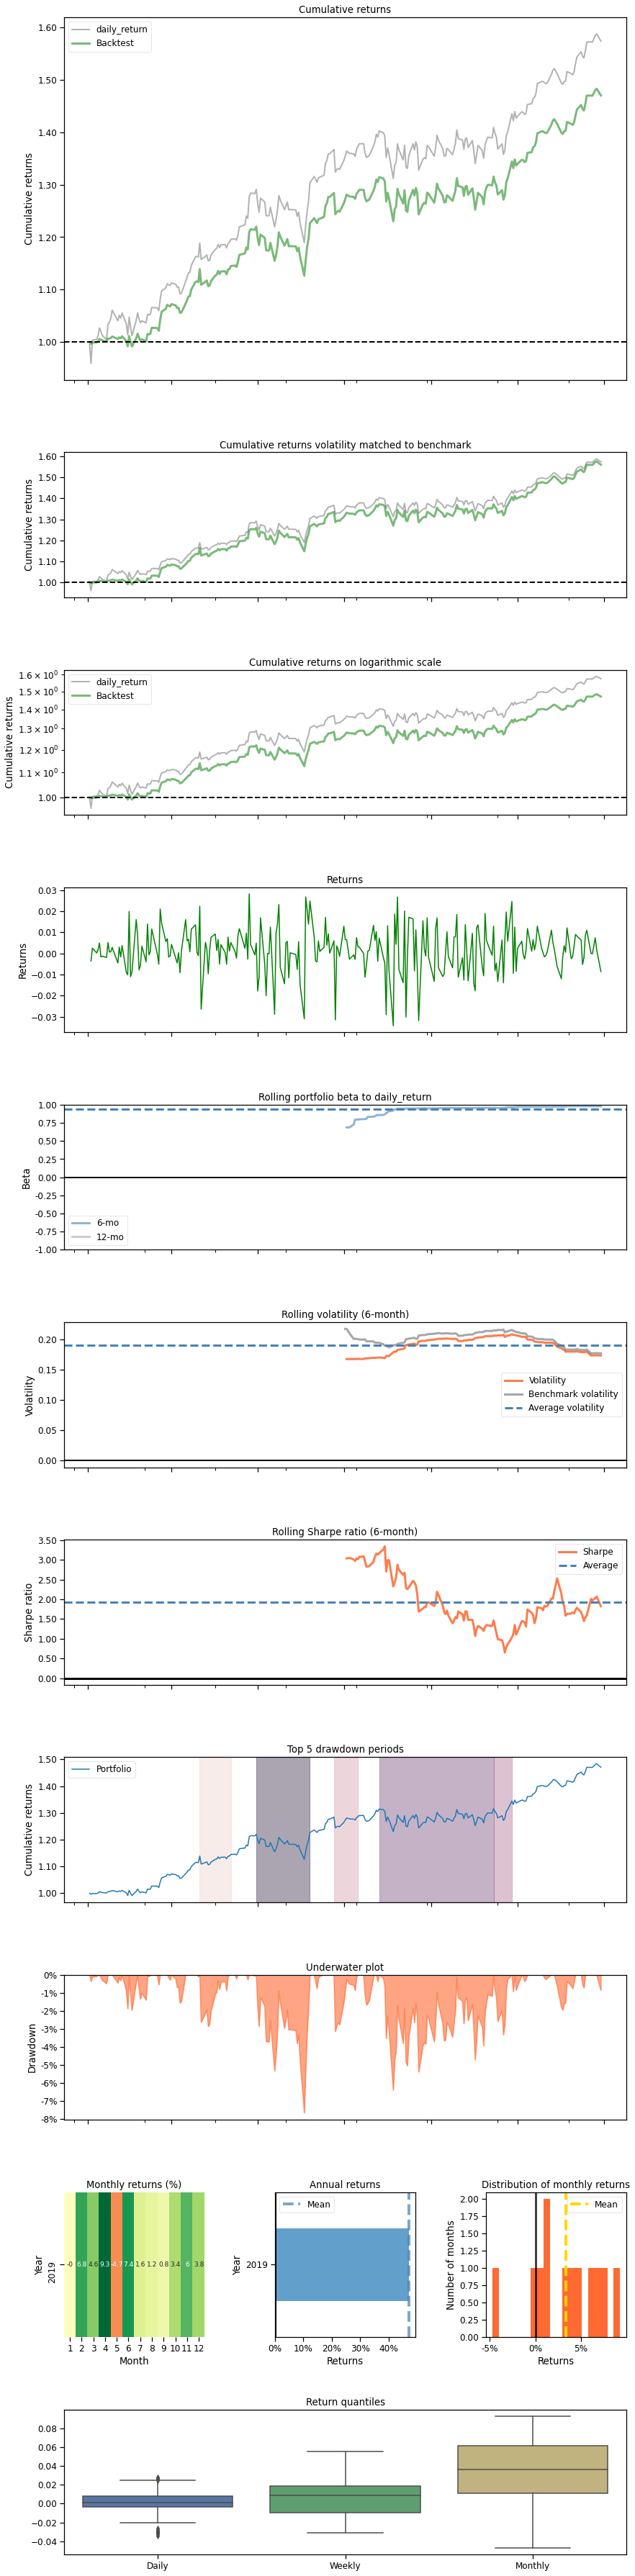

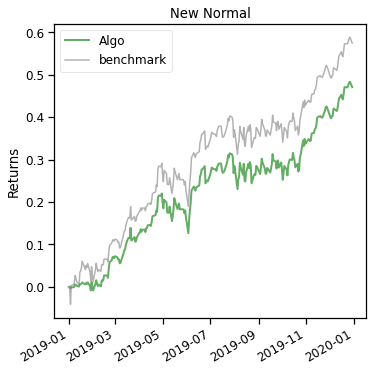

In [4]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)


# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_trade_gym)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 3e-05, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_1
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.92e+05 |
|    total_cost       | 0        |
|    total_reward     | 2.92e+05 |
|    total_reward_pct | 292      |
|    total_trades     | 1508     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 57       |
|    time_elapsed     | 105      |
|    total timesteps  | 6036     |
| train/              |          |
|    actor_loss       | 162      |
|    critic_loss      | 11.2     |
|    ent_coef         | 0.12     |
|    ent_coef_loss    | 20       |
|    learning_rate    | 3e-05    |
|    n_updates        | 5935     |
----------------------------------
day: 1508, episode: 130
begin_total_asset: 100000.00
end_total_asset: 392230.76
total_reward: 292230.76
total_cost: 0.00
total_trad

Start date,2019-01-02
End date,2019-12-30
Total months,11
,Backtest
Annual return,51.8%
Cumulative returns,51.6%
Annual volatility,17.9%
Sharpe ratio,2.43
Calmar ratio,6.89
Stability,0.92
Max drawdown,-7.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.52,2019-04-30,2019-06-03,2019-06-07,29
1,6.24,2019-07-26,2019-08-05,2019-09-19,40
2,4.56,2019-09-19,2019-10-02,2019-10-15,19
3,4.39,2019-01-18,2019-02-01,2019-02-15,21
4,3.62,2019-10-15,2019-10-22,2019-10-28,10


Stress Events,mean,min,max
New Normal,0.17%,-3.42%,3.31%


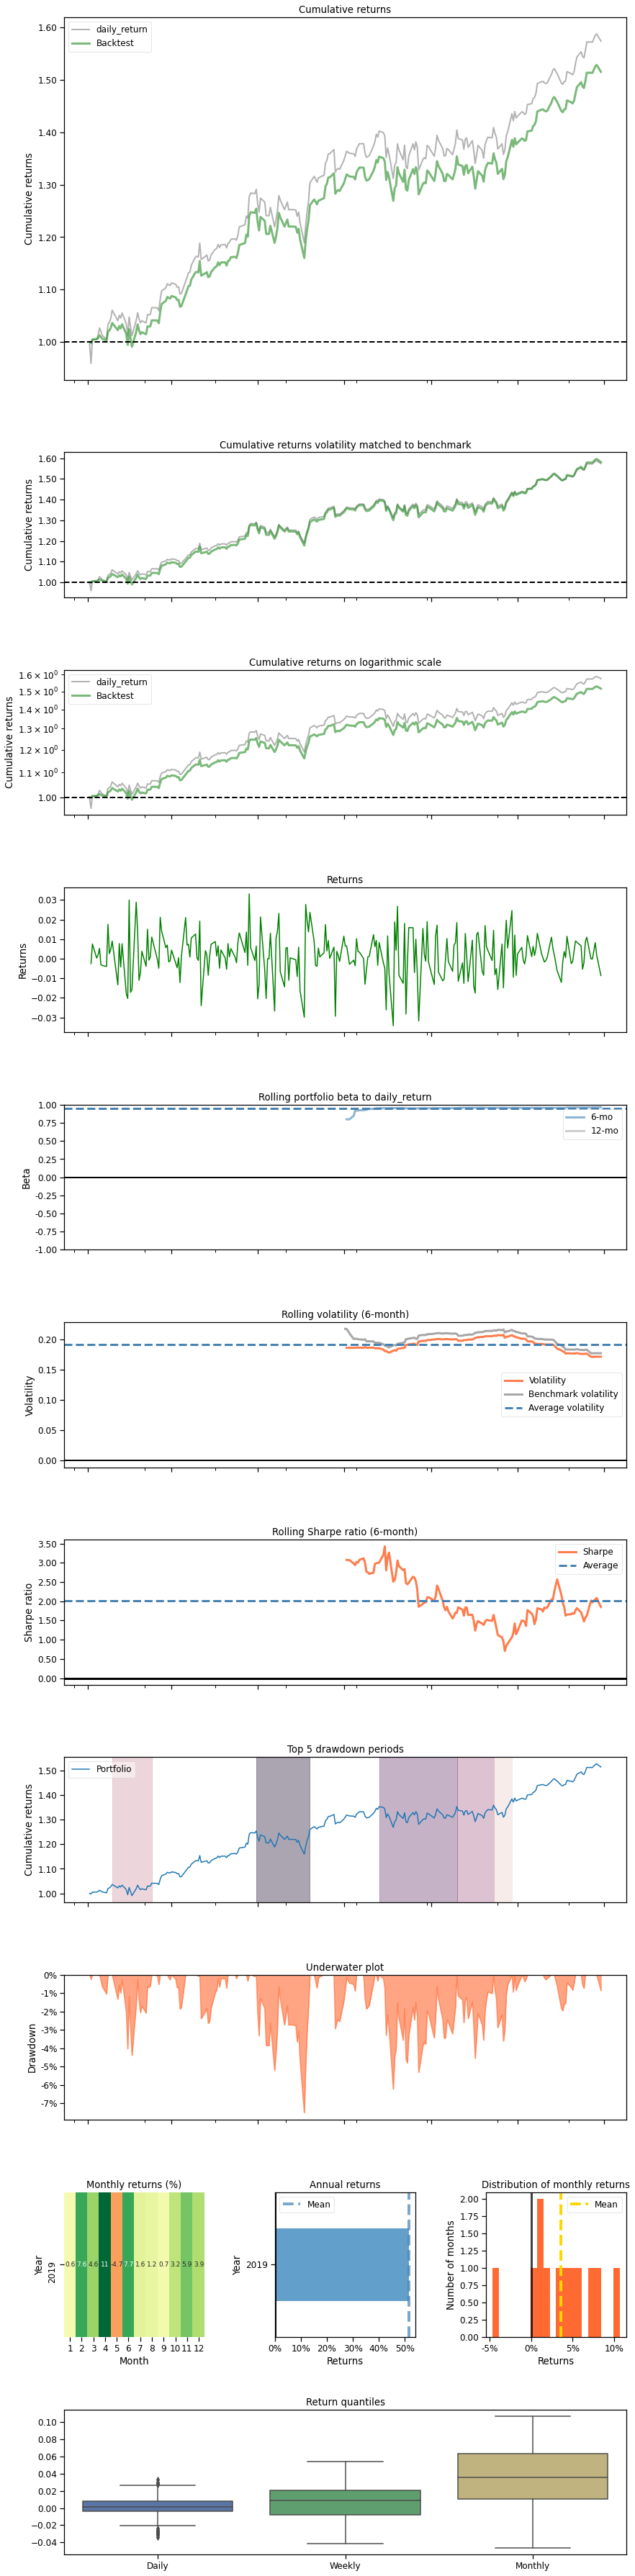

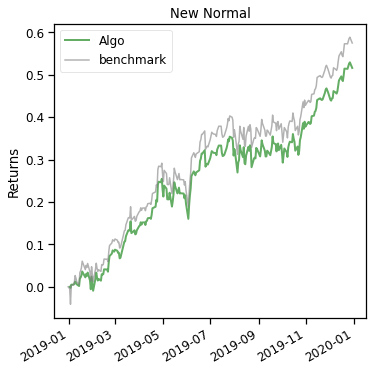

In [5]:
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.00003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=30000)
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_trade_gym)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

In [7]:
trained_a2c.save('trained_models/2021_4_17_a2c')

{'batch_size': 64, 'buffer_size': 500000, 'learning_rate': 0.0001}
Using cpu device
Logging to tensorboard_log/ddpg\ddpg_2
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+05    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 132      |
|    time_elapsed     | 45       |
|    total timesteps  | 6036     |
| train/              |          |
|    actor_loss       | 640      |
|    critic_loss      | 1.42e+03 |
|    learning_rate    | 0.0001   |
|    n_updates        | 4527     |
----------------------------------
day: 1508, episode: 150
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+05    |
|    total

Start date,2019-01-02
End date,2019-12-30
Total months,11
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.0
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.0,2019-01-02,2019-01-02,2019-01-02,1
1,0.0,2019-01-02,2019-01-02,2019-01-02,1
2,0.0,2019-01-02,2019-01-02,2019-01-02,1
3,0.0,2019-01-02,2019-01-02,2019-01-02,1
4,0.0,2019-01-02,2019-01-02,2019-01-02,1


Stress Events,mean,min,max
New Normal,0.00%,0.00%,0.00%


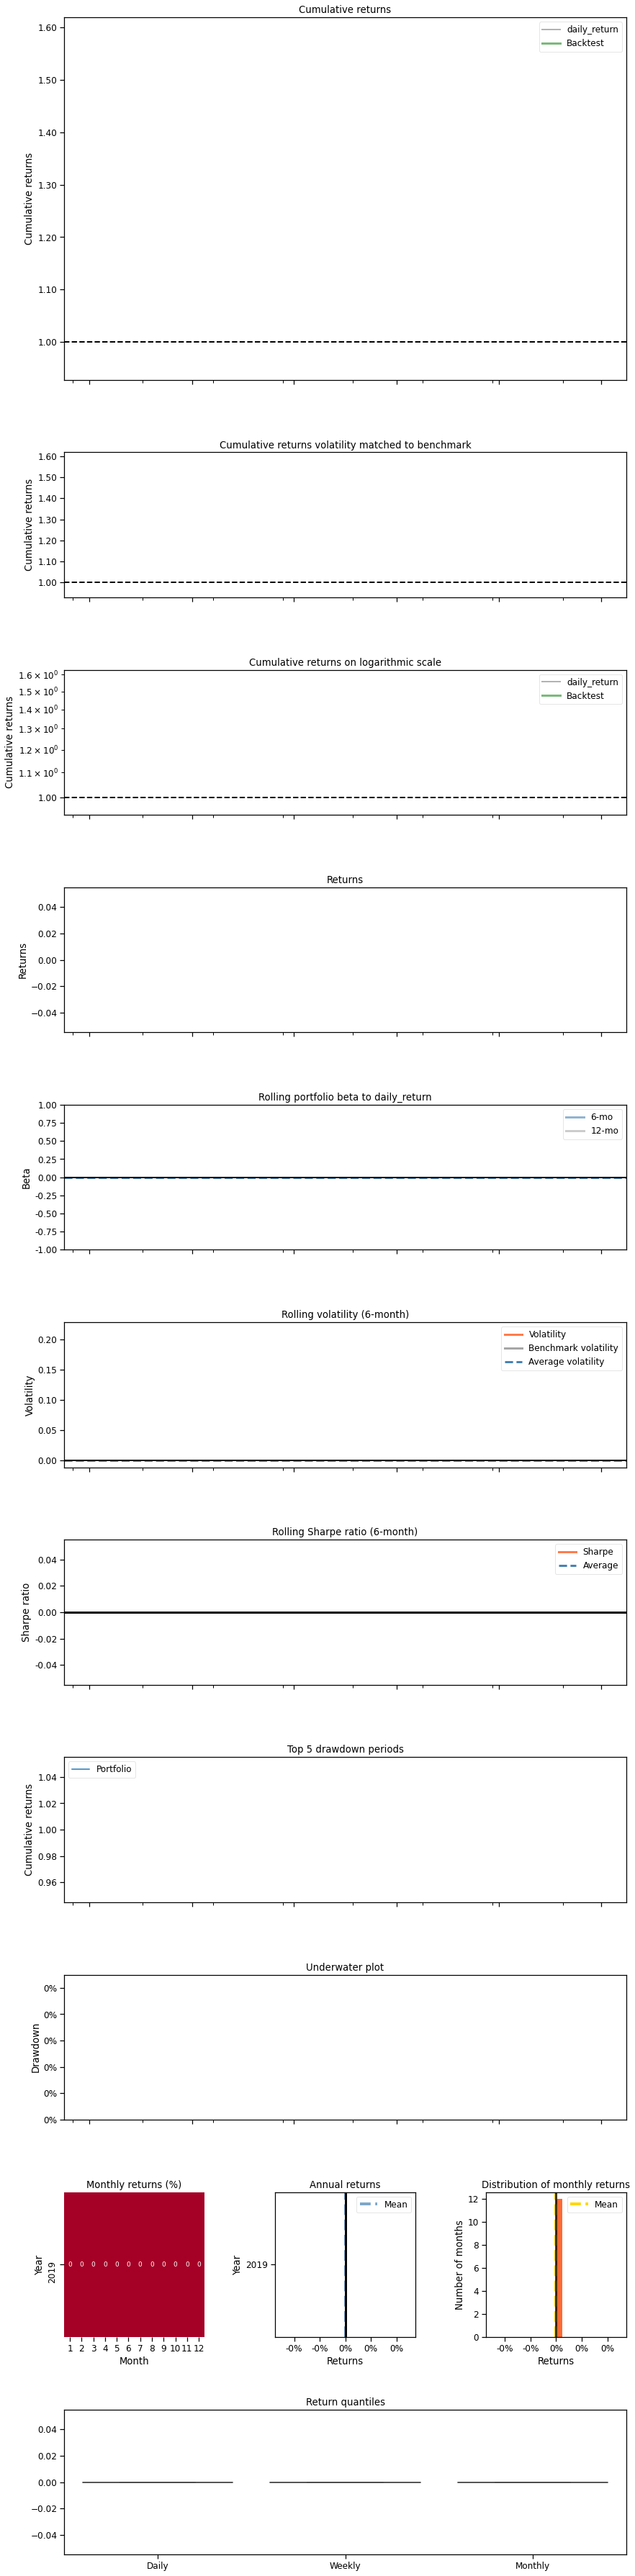

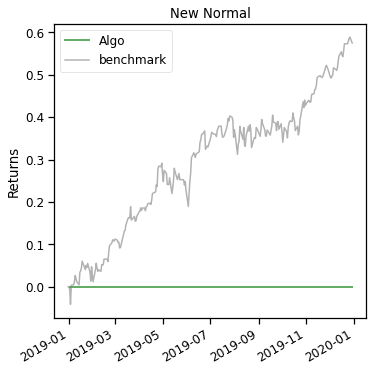

In [8]:
DDPG_PARAMS = {"batch_size": 64, "buffer_size": 500000, "learning_rate": 0.0001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=30000)
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg, environment=e_trade_gym)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

In [2]:
load_model = model_a2c.load('trained_models/2021_4_17_a2c')
df_account_value, df_actions = DRLAgent.DRL_prediction(model=load_model, environment=e_trade_gym)
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_" + now + '.csv')
print(f"==============Compare to {stock} itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = stock,
             baseline_start = '2019-01-01',
             baseline_end = '2019-12-31')

NameError: name 'model_a2c' is not defined

In [1]:
df_actions.head()

NameError: name 'df_actions' is not defined